# Introduction

Notebook to aggregate the running of models in the context of traceability between features and bug reports.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval
from modules.utils import similarity_measures as sm

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
models_runner_4 = Feat_BR_Models_Runner()
lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

evaluator_4 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_volunteers_df().T)
evals_df_4 = evaluator_4.run_evaluator(models=[lsi_model_4,lda_model_4,bm25_model_4,w2v_model_4],
                                       top_values=[1,3,5,10], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Feat_BR Volunteers Matrix shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [3]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.4,1.0,Bug_Number 1248267 1248268 125...


### Plots

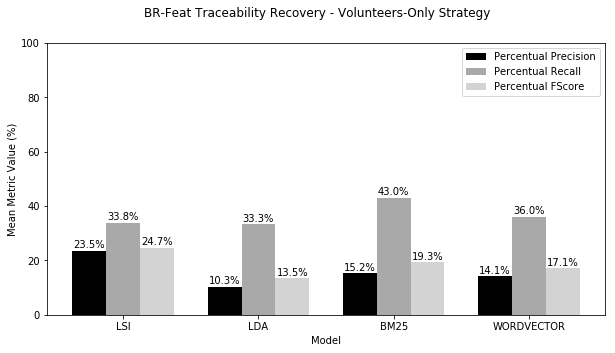

In [4]:
evaluator_4.plot_evaluations_3(evals_df_4, title='BR-Feat Traceability Recovery - Volunteers-Only Strategy')

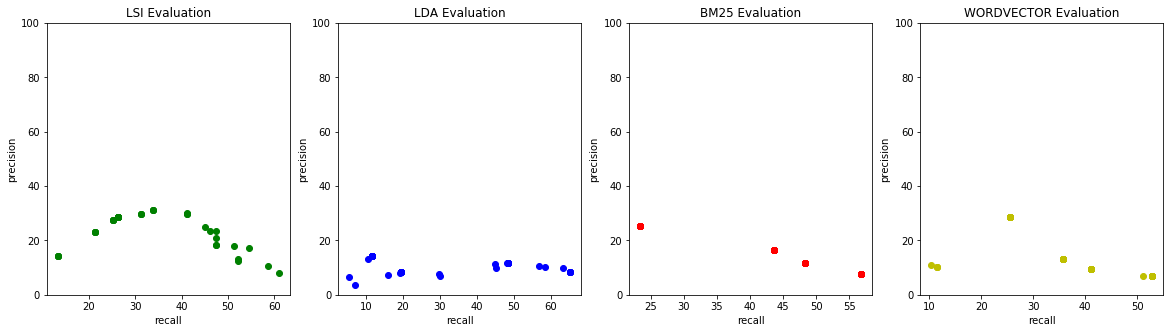

In [5]:
evaluator_4.plot_evaluations_4(evals_df_4)

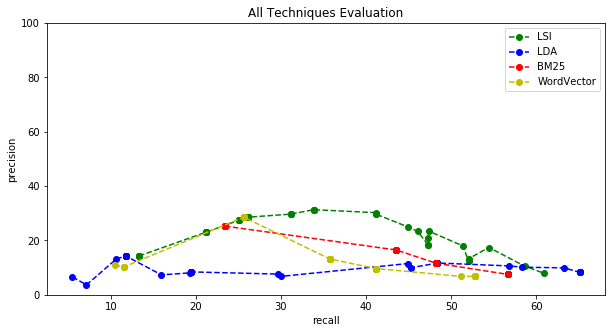

In [6]:
evaluator_4.plot_evaluations_5(evals_df_4)

### Delete Variables

## Union Strategy

In [7]:
models_runner_1 = Feat_BR_Models_Runner()
lsi_model_1 = models_runner_1.run_lsi_model()
lda_model_1 = models_runner_1.run_lda_model()
bm25_model_1 = models_runner_1.run_bm25_model()
w2v_model_1 = models_runner_1.run_word2vec_model()

evaluator_1 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_union_df().T)
evals_df_1 = evaluator_1.run_evaluator(models=[lsi_model_1,lda_model_1,bm25_model_1,w2v_model_1], 
                                       top_values=[1,3,5,10], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Expert and Volunteers Matrix UNION.shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [8]:
evals_df_1.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,42.86,33.78,36.21,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,42.86,33.78,36.21,precision recall fscore Bug_Nu...,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,42.86,33.78,36.21,precision recall fscore Bug_Nu...,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,42.86,33.78,36.21,precision recall fscore Bug_Nu...,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,42.86,33.78,36.21,precision recall fscore Bug_Nu...,0.4,1.0,Bug_Number 1248267 1248268 125...


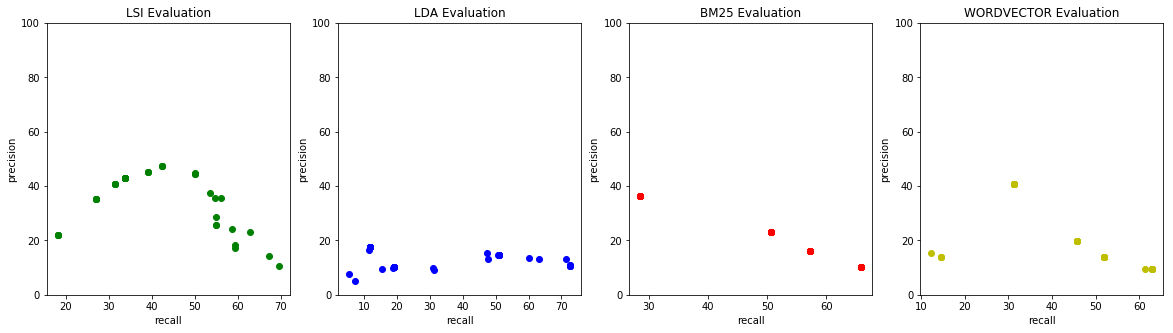

In [9]:
evaluator_1.plot_evaluations_4(evals_df_1)

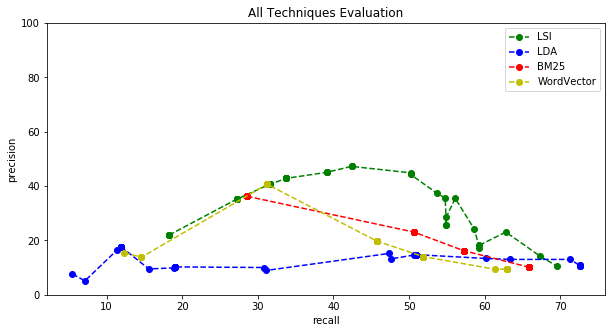

In [10]:
evaluator_1.plot_evaluations_5(evals_df_1)

### Plots

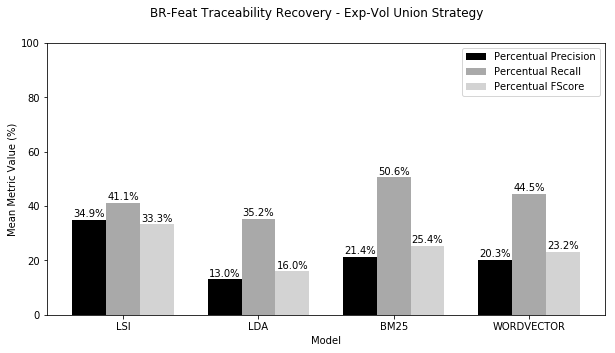

In [11]:
evaluator_1.plot_evaluations_3(evals_df_1, title='BR-Feat Traceability Recovery - Exp-Vol Union Strategy')

### Delete Variables

## Intersec Strategy

In [12]:
models_runner_2 = Feat_BR_Models_Runner()
lsi_model_2 = models_runner_2.run_lsi_model()
lda_model_2 = models_runner_2.run_lda_model()
bm25_model_2 = models_runner_2.run_bm25_model()
w2v_model_2 = models_runner_2.run_word2vec_model()

evaluator_2 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_volunteers_intersec_df().T)
evals_df_2 = evaluator_2.run_evaluator(models=[lsi_model_2,lda_model_2, bm25_model_2, w2v_model_2],
                                      top_values=[1,3,5,10], 
                                      sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Expert and Volunteers Matrix INTERSEC.shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [13]:
evals_df_2.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,26.37,25.82,26.01,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,26.37,25.82,26.01,precision recall fscore Bug_Nu...,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,26.37,25.82,26.01,precision recall fscore Bug_Nu...,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,26.37,25.82,26.01,precision recall fscore Bug_Nu...,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,26.37,25.82,26.01,precision recall fscore Bug_Nu...,0.4,1.0,Bug_Number 1248267 1248268 125...


### Plots

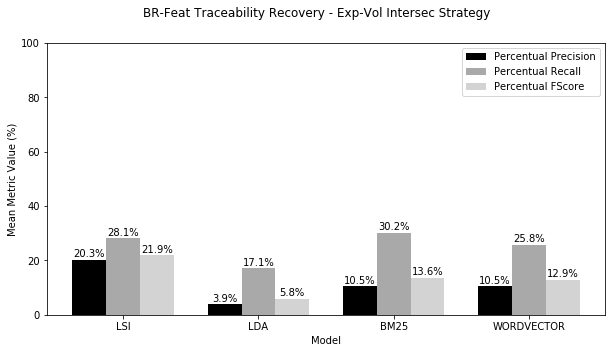

In [14]:
evaluator_2.plot_evaluations_3(evals_df_2, title='BR-Feat Traceability Recovery - Exp-Vol Intersec Strategy')

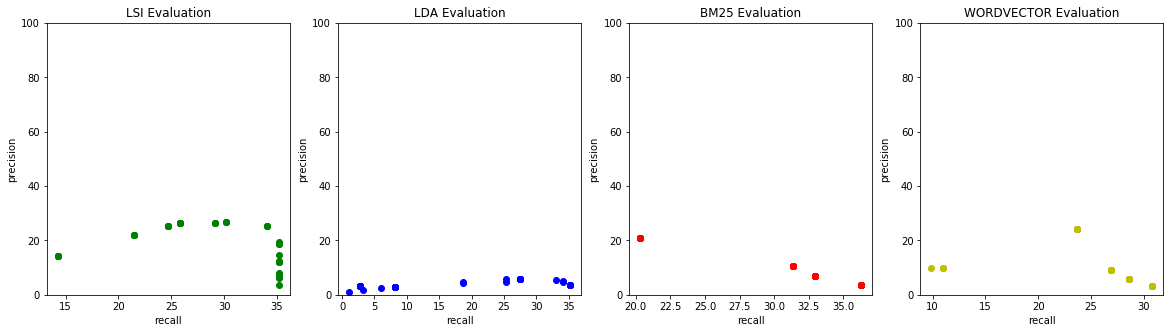

In [15]:
evaluator_2.plot_evaluations_4(evals_df_2)

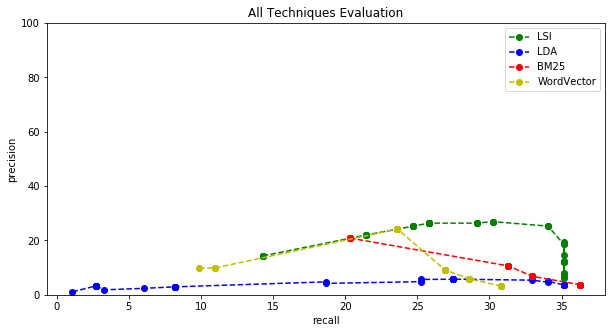

In [16]:
evaluator_2.plot_evaluations_5(evals_df_2)

### Delete Variables

## Expert Only Strategy

In [17]:
models_runner_3 = Feat_BR_Models_Runner()
lsi_model_3 = models_runner_3.run_lsi_model()
lda_model_3 = models_runner_3.run_lda_model()
bm25_model_3 = models_runner_3.run_bm25_model()
w2v_model_3 = models_runner_3.run_word2vec_model()

evaluator_3 = m_eval.ModelEvaluator(oracle=fd.Feat_BR_Oracles.read_feat_br_expert_df().T)
evals_df_3 = evaluator_3.run_evaluator(models=[lsi_model_3, lda_model_3, bm25_model_3, w2v_model_3],
                                       top_values=[1,3,5,10], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Feat_BR Expert Matrix shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Results

In [18]:
evals_df_3.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,40.66,37.73,38.64,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,40.66,37.73,38.64,precision recall fscore Bug_Nu...,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,40.66,37.73,38.64,precision recall fscore Bug_Nu...,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,40.66,37.73,38.64,precision recall fscore Bug_Nu...,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,40.66,37.73,38.64,precision recall fscore Bug_Nu...,0.4,1.0,Bug_Number 1248267 1248268 125...


### Plots

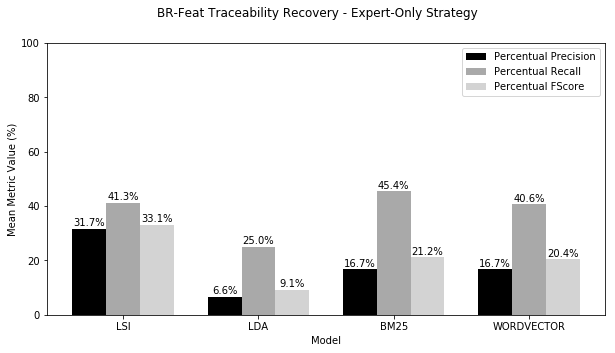

In [19]:
evaluator_3.plot_evaluations_3(evals_df_3, title='BR-Feat Traceability Recovery - Expert-Only Strategy')

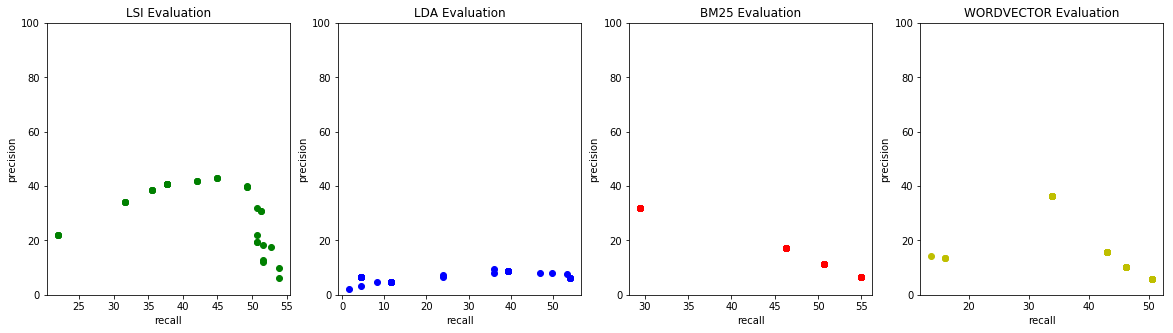

In [20]:
evaluator_3.plot_evaluations_4(evals_df_3)

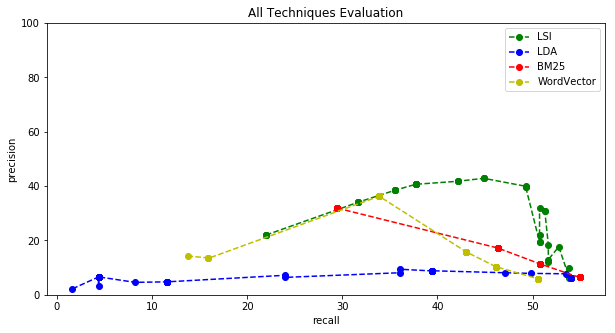

In [21]:
evaluator_3.plot_evaluations_5(evals_df_3)

### Delete Variables

del lsi_model_3, lda_model_3, bm25_model_3, w2v_model_3
del evals_df_3
del models_runner_3, evaluator_3